# Graph Neural Networks

Nowadays, a lot of information are represented in graphs. For example Google’s Knowledge Graph that helps with the Search Engine Optimization (SEO), chemical molecular structur. A graph, as you all know, is just a collection of vertices and edges.
Graphical Neural Networks can be used in cases where traditional ML/ CNNs fail such as CNNs works only on data with regular structure (Euclidean data), like images (2-dimensional) and text (1-dimensional), while GNN is a way to generalize CNN to work on data in non-Euclidean domain. In fact we can view Convolution as a special case of a GNN.

 The non-regularity of data structures have led to recent advancements in Graph Neural Networks. 

The First Question we are faced with is how to define Features for a Graphical Neural Network. The Nodes can be thought of as some sort of an embedding vector. There are several methods to do this:
1) Adjacency Matrix: An adjacency matrix is a N x N matrix filled with either 0 or 1, where N is the total number of nodes. Adjacency matrices are able to represent the existence of edges the connect the node pairs through the value in the matrices. 

2) Node attributes matrix (X):Unlike adjacency matrices that models the relationship between nodes, this matrix represents the features or attributes of each node. If there are N nodes and the size of node attributes is F, then the shape of this matrix is N x F.

3) Edge attributes matrix (E): Sometimes, edges can have its own attributes too, just like nodes. If the size of edge attributes is S and the number of edges available is n_edges, the shape of this matrix is n_edges x S.

**Working**
A GNN can be viewed as :

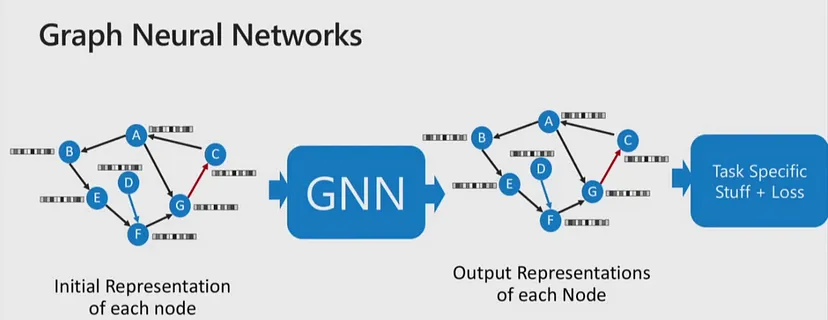

Here each Node has a distributed vector or we can think about it as a form of an embedding. It is this embedding that we work on. The first graph is just the representation of the the graph with its own vector, however the second graph's nodes's vectors have context about the node from its neighbours. So as we increase our training steps, the 'receptive field' ie.e the no of nodes that influence our current nodde increases. This happens because while or current node is influenced by its neighbours the neighbour is influenced by its neighbours and so one, hence we are able to get incorporate data from all nodes.
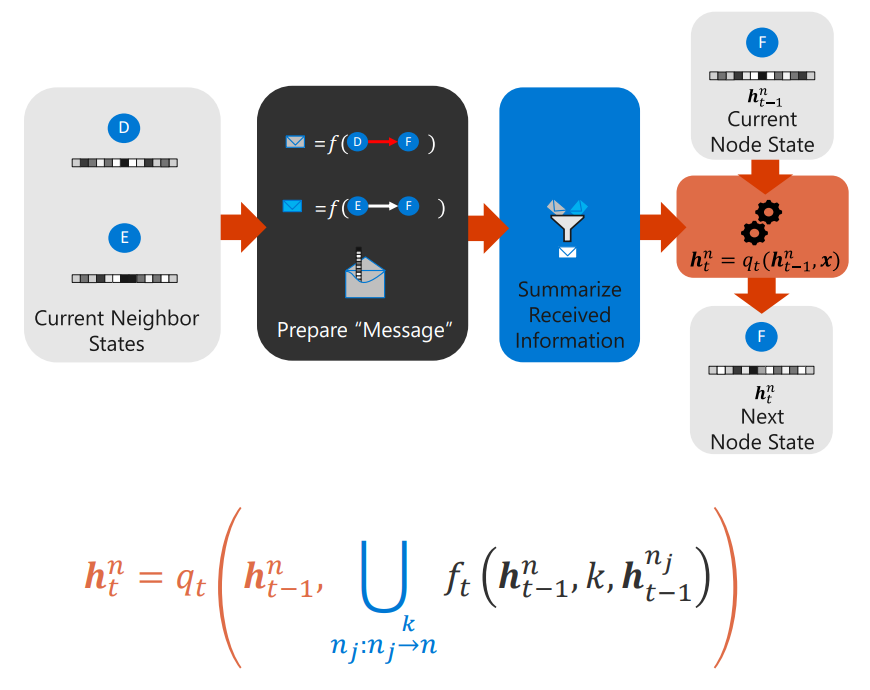



There are 2 basic models of GNNs:
1. Gated GNN-Uses GRUs

2. Graphical Convolutional Networks

Here in this notebook we are going to work upon GCNs.

# GCNs

If we want to classify chemical molecules, we will consider each molecule as 1 different graph; so in this setting, the number of the graphs we have will be as many as the number of the molecules. We call this Batch Mode.

On the other hand, if we want to classify documents within a document citation network, we will only have 1 big graph consisting of all the documents as the nodes. In this setting, we will call it Single Mode.

To illustrate the difference between GNNs and CNNs we can look at how a GCn looks at a digit:

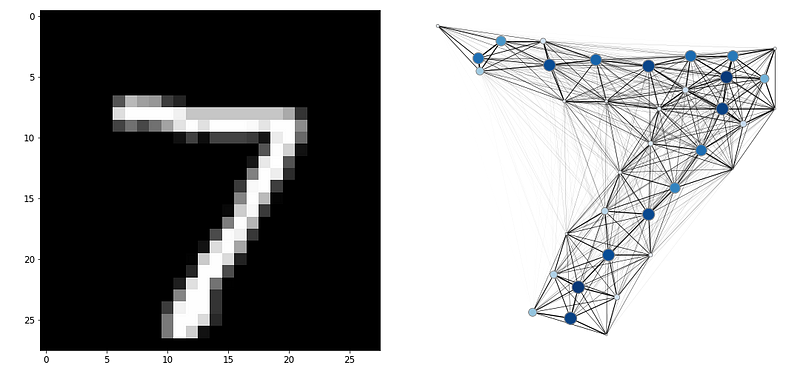

**Creating a graph using networkx**


Graph Nodes:  [(0, {'name': 0}), (1, {'name': 1}), (2, {'name': 2}), (3, {'name': 3}), (4, {'name': 4}), (5, {'name': 5}), (6, {'name': 6}), (7, {'name': 7})]


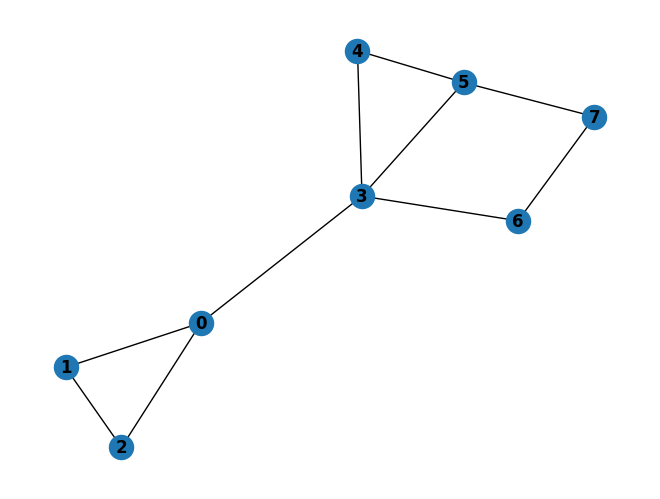

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


#Initializing the graph
G = nx.Graph(name='G')

#Creating nodes

for i in range(8):
    G.add_node(i, name=i)


#Define the edges 
edges = [(0,1),(0,2),(1,2),(0,3),(3,4),(3,5),(4,5),(6,7),(7,5),(3,6)]
G.add_edges_from(edges)

print('\nGraph Nodes: ', G.nodes.data())

#Plot the graph
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()



In [2]:
#Get the Adjacency Matrix (A) and Node Features Matrix (X) as numpy array
node_attr = 'name'
A = np.array(nx.attr_matrix(G, node_attr=node_attr)[0])
X = np.array(nx.attr_matrix(G, node_attr=node_attr)[1])
#X = np.expand_dims(X, axis=1)
X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (8, 8)

Shape of X:  (8, 1)

Adjacency Matrix (A):
 [[0. 1. 1. 1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0.]]

Node Features Matrix (X):
 [[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]]


In [3]:
#Dot product Adjacency Matrix (A) and Node Features (X)
AX = np.dot(A,X)
print("Dot product of A and X (AX):\n", AX)

Dot product of A and X (AX):
 [[ 6.]
 [ 2.]
 [ 1.]
 [15.]
 [ 8.]
 [14.]
 [10.]
 [11.]]


From the results, it is apparent that AX represents the sum of neighboring nodes features, but neither is the result normalised nor does it take into account its own features. For this we need to add self loops, and then we noramlize using Degree Matrix,a the diagonal matrix containing the number of edges attached to each vertex, and calculating its dot product with AX. However,Kipf and Welling suggests symmetric normalization so we use D^(-1/2)AD^(-1/2) as our normalization term.

The 'magic' of GCN is that it can learn features representation even without training.

In [4]:
G_sloops = G.copy()

self_loops = []
for i in range(G.number_of_nodes()):
    self_loops.append((i,i))

G_sloops.add_edges_from(self_loops)



#Get the Adjacency Matrix (A) and Node Features Matrix (X) of added self-lopps graph
A_hat = np.array(nx.attr_matrix(G_sloops, node_attr='name')[0])
print('Adjacency Matrix of added self-loops G (A_hat):\n', A_hat)

AX = np.dot(A_hat, X)
print('AX:\n', AX)

Adjacency Matrix of added self-loops G (A_hat):
 [[1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1.]]
AX:
 [[ 6.]
 [ 3.]
 [ 3.]
 [18.]
 [12.]
 [19.]
 [16.]
 [18.]]


In [5]:
Deg_Mat = G_sloops.degree()
print('Degree Matrix of added self-loops G (D): ', Deg_Mat)

#Convert the Degree Matrix to a N x N matrix 
D = np.diag([deg for (n,deg) in list(Deg_Mat)])
print('Degree Matrix of added self-loops G as numpy array (D):\n', D)


D_inv = np.linalg.inv(D)#inverse of degree matrix
print('Inverse of D:\n', D_inv)



D_half_norm = fractional_matrix_power(D, -0.5)
DADX = D_half_norm.dot(A_hat).dot(D_half_norm).dot(X)#normalization
print('DADX:\n', DADX)

Degree Matrix of added self-loops G (D):  [(0, 5), (1, 4), (2, 4), (3, 6), (4, 4), (5, 5), (6, 4), (7, 4)]
Degree Matrix of added self-loops G as numpy array (D):
 [[5 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0]
 [0 0 4 0 0 0 0 0]
 [0 0 0 6 0 0 0 0]
 [0 0 0 0 4 0 0 0]
 [0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 4]]
Inverse of D:
 [[0.2        0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.25       0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.25       0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.16666667 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.25       0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.2
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.25       0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        

In [6]:
np.random.seed(42)
#hidden layers
n_h =8
n_h2=8
n_h3=4
#output layer
n_y = 2 
W0 = np.random.randn(X.shape[1],n_h) * 0.01
W1 = np.random.randn(n_h,n_h2) * 0.01
W2 = np.random.randn(n_h2,n_h3) * 0.01
W3 = np.random.randn(n_h3,n_y) * 0.01

#Implement ReLu as activation function
def relu(x):
    return np.maximum(0,x)

#Building GCN layer
def gcn(A,H,W):
    I = np.identity(A.shape[0]) #create Identity Matrix of A
    A_hat = A + I #add self-loop to A
    D = np.diag(np.sum(A_hat, axis=0)) #create Degree Matrix of A
    
    
    D_half_norm = fractional_matrix_power(D, -0.5) #calculate D to the power of -0.5
    eq = D_half_norm.dot(A_hat).dot(D_half_norm).dot(H).dot(W)
    return relu(eq)


#forward propagation
H1 = gcn(A,X,W0)
H2 = gcn(A,H1,W1)
H3 = gcn(A,H2,W2)
H4 = gcn(A,H3,W3)

print('Features Representation from GCN output:\n', H4)

Features Representation from GCN output:
 [[8.07455510e-09 0.00000000e+00]
 [5.15558893e-09 0.00000000e+00]
 [5.15558893e-09 0.00000000e+00]
 [1.61093395e-08 0.00000000e+00]
 [1.34734536e-08 0.00000000e+00]
 [1.63871538e-08 0.00000000e+00]
 [1.47871317e-08 0.00000000e+00]
 [1.54512233e-08 0.00000000e+00]]


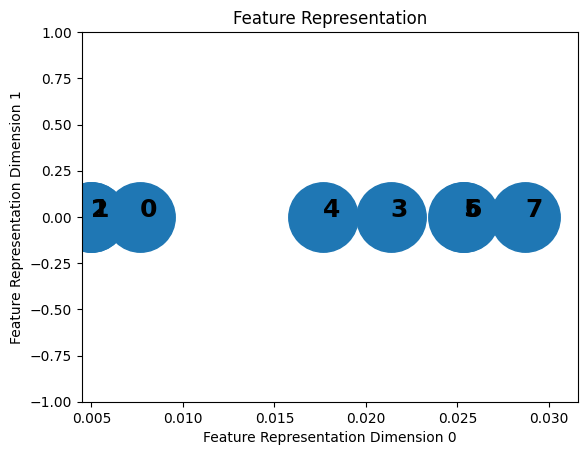

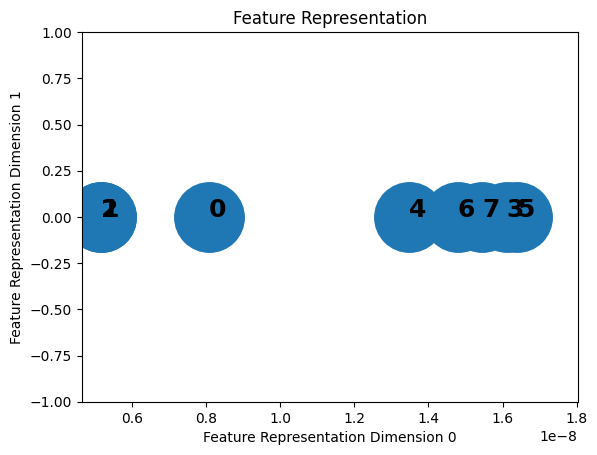

In [7]:
def plot_features(hidden):
    
    x = hidden[:,0]
    y = hidden[:,1]

    size = 2500

    plt.scatter(x,y,size)
    plt.xlim([np.min(x)*0.9, np.max(x)*1.1])
    plt.ylim([-1, 1])
    plt.xlabel('Feature Representation Dimension 0')
    plt.ylabel('Feature Representation Dimension 1')
    plt.title('Feature Representation')

    for i,row in enumerate(hidden):
        str = "{}".format(i)
        plt.annotate(str, (row[0],row[1]),fontsize=18, fontweight='bold')

    plt.show()

plot_features(H1)
plot_features(H4)

I had gone through a couple of resources in order to make this notebook, you can refer to these works:

1) https://arxiv.org/pdf/1609.02907.pdf

2) https://towardsdatascience.com/graph-convolutional-networks-on-node-classification-2b6bbec1d042

3) https://youtu.be/zCEYiCxrL_0?si=Gdnd_vWEenx032hD(The source of the images)